## Caution
Shoud I consider the guard time?

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from Cyclist_env_RDA import cyclist_env
from time import time
from scipy.linalg import dft
import torch
import numpy as np
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment


In [47]:
# Program No.1
def ca_cfar_2d(x_db, n_train=(1,7), n_guard=(1,5), pfa=1e-6, convert_from_db=False):
    """
    x_db: (B,1,H,W) input map (dB or linear)
    n_train: (th, tw) training half window size
    n_guard: (gh, gw) guard half window size
    """
    if convert_from_db:
        x = 10 ** (x_db / 10.0)  # dB -> linear
    else:
        x = x_db

    B, C, H, W = x.shape
    th, tw = n_train
    gh, gw = n_guard

    # Total kernel size
    kh = 2 * (th + gh) + 1
    kw = 2 * (tw + gw) + 1

    # Make training mask
    kernel = torch.ones((1,1,kh,kw), device=x.device)
    kernel[:, :, th-gh:th+gh+1, tw-gw:tw+gw+1] = 0  # guard + CUT = 0

    N_train = kernel.sum().item()
    alpha = N_train * (pfa ** (-1.0 / N_train) - 1.0)

    # Convolution = training sum
    x_pad = F.pad(x, (kw//2, kw//2, kh//2, kh//2), mode="reflect")
    train_sum = F.conv2d(x_pad.double(), kernel.double())
    noise_est = train_sum / N_train

    threshold = alpha * noise_est
    detections = x > threshold
    return detections, threshold, noise_est

def thresholder(radar, idx_est, tar_thres = -25, cyvethres = 2.638):
    cy_idx, ve_idx = [], []
    radar = 20*torch.log10(radar)
    for i in range(len(idx_est)):
        rangeofinterest = radar[:5, max(0, idx_est[i]-5):min(idx_est[i]+5, 589)].flatten()
        top2 = rangeofinterest.topk(2).values.mean()
        if top2 > tar_thres:
            cy_idx.append(idx_est[i])
            ve_idx.append(idx_est[i]) 

    cy_idx_cleans = cleansing(cy_idx)
    ve_idx_cleans = cleansing(ve_idx)

    return cy_idx_cleans, ve_idx_cleans
    
def cleansing(idx, tol = 5):
    if idx :
        res = [idx[0]]
        for i in range(1,len(idx)):
            if idx[i]<=idx[i-1]+5:
                continue
            res.append(idx[i])
        return res
    else: return []

## Coefficients

In [48]:
# Program No.2
###### symbol time & carrier frequency ######
T_symbol = 1.115 * 1e-6              # symbol duration, with CP time
T_OFDM = 1.0425 * 1e-6
f_carrier = 28 * 1e+9
Tc = 0.509*1e-9                      # sampling time

###### tx/rx ######
N_ant = 16                       # the number of antennas
BW = 1.966080e+9                      # chirp bandwidth
BW_sub = BW/N_ant
N_sample = int(np.floor(T_symbol/Tc))           # the number of samples of single chirp
rx_sample = 4000 + N_sample



###### Radar setting ######

N_chirp = 100                    # the number of chirps
mu = BW_sub/T_symbol * 0.98
Q = 30
Phi = 0.3*np.pi

l_speed = 299792458

env = cyclist_env(f_carrier, N_ant, BW, BW_sub, N_sample, rx_sample, Tc, mu, l_speed)

In [49]:
1/T_symbol/2*l_speed/f_carrier

4801.288565022422

In [50]:
# Program No.3
def stevec(N_ant, angle):
    resp = (np.arange(N_ant)-N_ant*0.5+0.5).reshape([-1,1])
    resp = np.exp(1j*resp*np.pi*np.sin(angle))
    return np.matrix(resp)

In [54]:
# Program No.4
## Here is the point to change. like draw some values for the position of the vehicle, and put it out that here.
## the I guess there is efficient way to merge the delayed versions of the waveform.
## for right now, just forget about the efficiency, just code it.
## All you care about is the Doppler.
## There is some value I cut off.
x_pos = list(np.arange(-450, -149)/10)
p_bs = np.array([250, -18, 50])


# num_cy = np.random.randint(1, 3)
num_cy = 1

cy_idx = np.zeros(num_cy, dtype=np.int32)
p_cy, v_cy = np.zeros((num_cy, 3)), np.zeros((num_cy, 3))
i=0
s = set()
while i < num_cy:
    # idx = np.random.randint(0, 301, 1)[0]
    idx = 0
    # 初期値における距離間隔を保証するための処理
    if idx+10 in s or idx-10 in s or idx in s: continue
    for j in range(-20,20): s.add(idx+j)
    
    cy_idx[i] = idx
    p_cy[i] = np.array([x_pos[idx], 15, 1])
    # v_cy[i] = np.array([np.random.rand(1)[0]*5.56, 0, 0])
    v_cy[i] = np.array([0, 0, 0])
    
    i+=1
n_cy = len(p_cy)


# num_ve = np.random.randint(1, 3)
num_ve = 1

ve_idx = np.zeros(num_ve, dtype=np.int32)
p_ve, v_ve = np.zeros((num_ve, 3)), np.zeros((num_ve, 3))

s = set()
i=0
while i < num_ve:
    # idx = np.random.randint(0, 301, 1)[0]
    idx = 0
    
    if idx+20 in s or idx-20 in s or idx in s: continue
    for j in range(-20,20): s.add(idx+j)
    ve_idx[i] = idx
    p_ve[i] = np.array([x_pos[idx], 7.5, 1])
    # v_ve[i] = np.array([np.random.rand(1)[0]*11.11, 0, 0])
    # 0~10
    v_ve[i] = np.array([0, 0, 0])
    
    i+=1

n_rp = 0

p_rp, v_rp = np.zeros((n_rp, 3)), np.zeros((n_rp, 3))

# p_rp[0] = np.array([-17.5, 17.8, 1])
# p_rp[1] = np.array([-27.5, 17.8, 1])
# p_rp[2] = np.array([-37.5, 17.8, 1])


n_ve = len(p_ve)
cy_idx += 1
ve_idx += 1
print(p_cy)
print('-------------')
print(p_ve)
print('-------------')
print(p_rp)

P_rx_cy, tstemp_rx_cy, phase_cy, P_rx_ve, tstemp_rx_ve, phase_ve, P_rx_rp, tstemp_rx_rp, phase_rp = [], [], [], [], [], [], [], [], []
for i in range(len(cy_idx)):
    df = pd.read_csv("./ped/0.5nano/complex-impulse-response-Run{:04d}-Sensor_0_Tx_0_to_Rx_0.csv".format(cy_idx[i]))
    tstemp_rx_cy.append(np.ceil((df["Time (s)"]/Tc).values[3:]))
    P_rx_cy.append(df["| Total Complex Impulse Response total | (W)"].values[3:])
    phase_cy.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[3:])
for i in range(len(ve_idx)):
    df = pd.read_csv("./vehicle/0.5nano/complex-impulse-response-Run{:04d}-Sensor_0_Tx_0_to_Rx_0.csv".format(ve_idx[i]))
    tstemp_rx_ve.append(np.ceil((df["Time (s)"]/Tc).values[3:]))
    P_rx_ve.append(df["| Total Complex Impulse Response total | (W)"].values[3:])
    phase_ve.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[3:])
for i in range(1,4):
    df = pd.read_csv("./Ramposts/"+str(i)+"/complex-impulse-response-Run0001-Sensor_0_Tx_0_to_Rx_0.csv")
    tstemp_rx_rp.append(np.ceil((df["Time (s)"]/Tc).values[5:]))
    P_rx_rp.append(df["| Total Complex Impulse Response total | (W)"].values[5:])
    phase_rp.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[5:])

phys_quantities = env.phys_quantities(p_bs, p_cy, v_cy, n_cy, p_ve, v_ve, n_ve, p_rp, v_rp, n_rp)
tx = env.tx()

######### We need some functions here. it is like this. read the csv. this outputs the time stemp and corresponding rx value.
# P_rx_cy_dB = -114
#P_rx_cy_dB = -111
#P_rx_ve_dB = -114
#P_rx_cy_dB = 0
#P_rx_ve_dB = 0

P_N_dB = -81 # target noise power when using 2GHz BW

N_trans = 100
sym_duration = rx_sample*Tc
Y = env.rx_multiple(tx, P_rx_cy, tstemp_rx_cy, phase_cy, P_rx_ve, tstemp_rx_ve, phase_ve, P_rx_rp, tstemp_rx_rp, phase_rp, P_N_dB, sym_duration, N_trans)

[[-45.  15.   1.]]
-------------
[[-45.    7.5   1. ]]
-------------
[]


In [55]:
# Program No.5
Y_music = np.mean(Y, axis=0)
R_yy = Y_music@np.conjugate(np.transpose(Y_music))
# print(np.linalg.eig(R_yy)[0])
U = np.linalg.eig(R_yy)[1][:,5:]

resp = []
argm = (np.arange(1800)-900)/100
for val in argm:
    stv = stevec(N_ant, val*np.pi/180)
    p = stv.T@U
    pp = p*np.conjugate(np.transpose(p))
    resp.append(1/(np.abs(pp)**2).A1)


cy_ang = env.result['angle']['cyclists']/np.pi*180
ve_ang = env.result['angle']['vehicles']/np.pi*180
rp_ang = env.result['angle']['ramposts']/np.pi*180

M = max(resp)
est_ang = []

a, b = resp[0][0], resp[1][0]
for i in range(1,len(argm)-1):
    c = resp[i+1][0]
    if a < b and b > c and b > 0.2 * M:
        est_ang.append(argm[i])
    a, b = b, c

print(est_ang)
print(env.result['angle']['cyclists'] /np.pi*180)
print(env.result['angle']['vehicles'] /np.pi*180)
#デバッグ用のコード?
est_ang = [est_ang[0]]

[np.float64(1.45)]
[2.83362038]
[1.39120342]


[300.85710894] [0.] [0.]
[300.12705643] [0.] [0.]


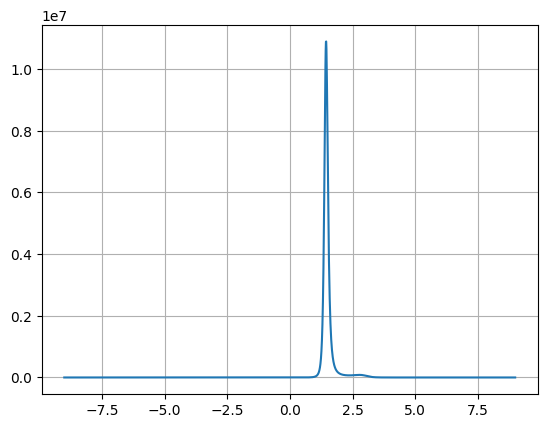

In [56]:
plt.plot(argm, resp), plt.grid()
print(np.array(env.result['range']['cyclists']), np.array(env.result['relative_velocity']['cyclists'])*3600/1000, np.array(env.result['relative_velocity']['cyclists']))
print(np.array(env.result['range']['vehicles']), np.array(env.result['relative_velocity']['vehicles'])*3600/1000, np.array(env.result['relative_velocity']['vehicles']))

In [ ]:
# Program No.6
Dopp_dft = dft(N_trans)/np.sqrt(N_trans)
Y_dft = np.zeros((N_trans, N_ant, rx_sample), dtype=np.complex128)
for i in range(N_ant):
    Y_dft[:,i,:] = Dopp_dft@Y[:,i,:]
val, res, rdresp = 0, [], np.zeros((N_trans,590), dtype=np.complex128)
Q = 1
# 処理に時間がかかるので，いったん繰り返しの範囲を絞る
P_range = np.arange(590)+3411
#P_range = np.arange(150) + 3800

pretime = time()
for i in range(len(est_ang)):
    ang = est_ang[i]*np.pi/180
    dup = np.ones((N_trans, 1, 1), dtype=np.complex128)
    for p in P_range:
        X_cand = np.zeros((N_ant, rx_sample), dtype=np.complex128)
        last = min(p+N_sample, rx_sample)
        X_cand[:,p:last] += tx[:,:last-p]
        g = np.conjugate(stevec(N_ant, ang))@np.conjugate(np.transpose(stevec(N_ant, ang)))@X_cand
        g_mat = dup*np.array(g)
        metric = np.sum(np.multiply(np.conjugate(Y_dft), g_mat), axis=(1,2))
        rdresp[:,p-3411] = metric
# np.save('./Data_withfewtargetsandobstacles/'+str(indexindex)+'.npy',rdresp)
aftertime = time()
print(aftertime - pretime)

23.01339864730835


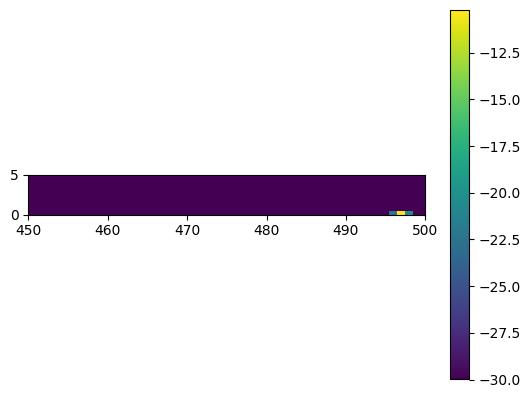

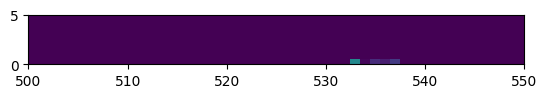

In [58]:
output = rdresp[:100,:] + 1e-10
i=9
plt.imshow(20*np.log10(abs(output)), vmin = -30)
# 変更点？
plt.ylim(0,5)
plt.xlim(0 + 50*i,50 + 50*i)
plt.colorbar()
plt.show()
i+=1
plt.imshow(20*np.log10(abs(output)), vmin = -30)
# 変更点？
plt.ylim(0,5)
plt.xlim(0 + 50*i,50 + 50*i)
# plt.colorbar()
plt.show()

In [59]:
# Program No.7
radar_in = torch.tensor(abs(rdresp[:20,:])).unsqueeze(0).unsqueeze(0)
detections, _, _ = ca_cfar_2d(radar_in, convert_from_db=False)
idx_est = torch.nonzero(detections[0,0,0], as_tuple=True)[0].tolist()
cy_idxs_pred, _ = thresholder(radar_in[0,0], idx_est)

In [60]:
idx_est

[401, 417, 433, 449, 465, 497, 498, 519, 533, 534, 535, 536, 537, 538]

In [61]:
cy_idxs_pred

[497, 533]